# With Preprocessed_EEG

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy.io as sio
import mne
import pandas as pd

In [2]:

file_path = 'E:/STUDY/Publications/Thesis/Brain Emotion Detection/Dataset/Practice with datasets/Seed/Preprocessed_EEG/1_20131027.mat'
#file_path = 'E:/STUDY/Publications/Thesis/Brain Emotion Detection/Dataset/Practice with datasets/Seed/ExtractedFeatures/1_20131027.mat'

mat_data = sio.loadmat(file_path)


In [3]:
#Explore Variable Names

variable_names = mat_data.keys()
print(variable_names)


dict_keys(['__header__', '__version__', '__globals__', 'djc_eeg1', 'djc_eeg2', 'djc_eeg3', 'djc_eeg4', 'djc_eeg5', 'djc_eeg6', 'djc_eeg7', 'djc_eeg8', 'djc_eeg9', 'djc_eeg10', 'djc_eeg11', 'djc_eeg12', 'djc_eeg13', 'djc_eeg14', 'djc_eeg15'])


In [20]:
for trial_index in range(1, 16):  # Assuming trial indices are from 1 to 15
    # Replace 'djc_eeg1' with the corresponding variable name containing EEG data for each trial
    variable_name = f'djc_eeg{trial_index}'
    eeg_data = mat_data[variable_name]

    # Print the shape of the EEG data for this trial
    print(f"Shape of EEG data for trial {trial_index}: {eeg_data.shape}")

Shape of EEG data for trial 1: (62, 47001)
Shape of EEG data for trial 2: (62, 46601)
Shape of EEG data for trial 3: (62, 41201)
Shape of EEG data for trial 4: (62, 47601)
Shape of EEG data for trial 5: (62, 37001)
Shape of EEG data for trial 6: (62, 39001)
Shape of EEG data for trial 7: (62, 47401)
Shape of EEG data for trial 8: (62, 43201)
Shape of EEG data for trial 9: (62, 53001)
Shape of EEG data for trial 10: (62, 47401)
Shape of EEG data for trial 11: (62, 47001)
Shape of EEG data for trial 12: (62, 46601)
Shape of EEG data for trial 13: (62, 47001)
Shape of EEG data for trial 14: (62, 47601)
Shape of EEG data for trial 15: (62, 41201)


# Load a signle channel data of a trial

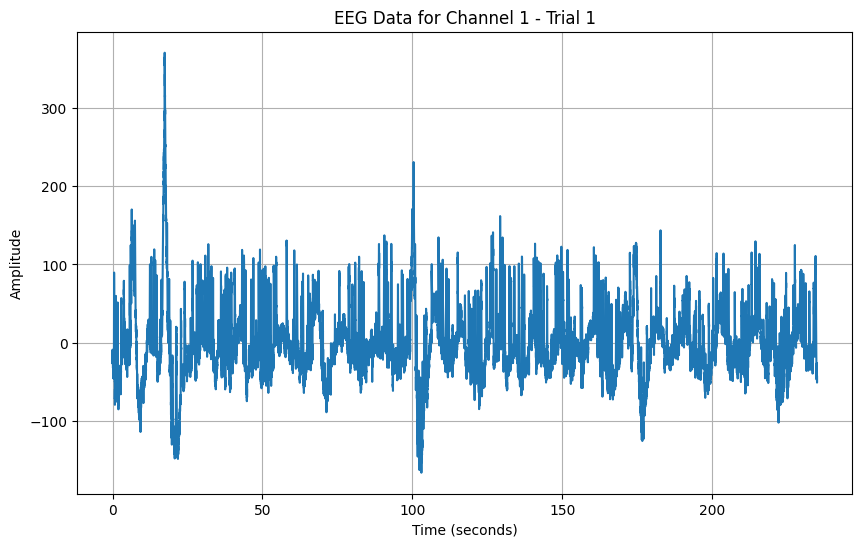

In [21]:
# Choose the channel index for plotting (0 for the first channel, 1 for the second channel, and so on)
channel_index = 0
eeg_trial_data = mat_data['djc_eeg1']
# Get the EEG data for the chosen channel
eeg_channel_data = eeg_trial_data[channel_index, :]

# Create a time vector for the x-axis (assuming a sampling rate of 200 Hz as mentioned in the dataset description)
sampling_rate = 200
time_vector = np.arange(len(eeg_channel_data)) / sampling_rate

# Plot the EEG data for the chosen channel
plt.figure(figsize=(10, 6))
plt.plot(time_vector, eeg_channel_data)
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.title(f'EEG Data for Channel {channel_index + 1} - Trial 1')
plt.grid(True)
plt.show()


# delta, theta, alpha, beta, gamma waves

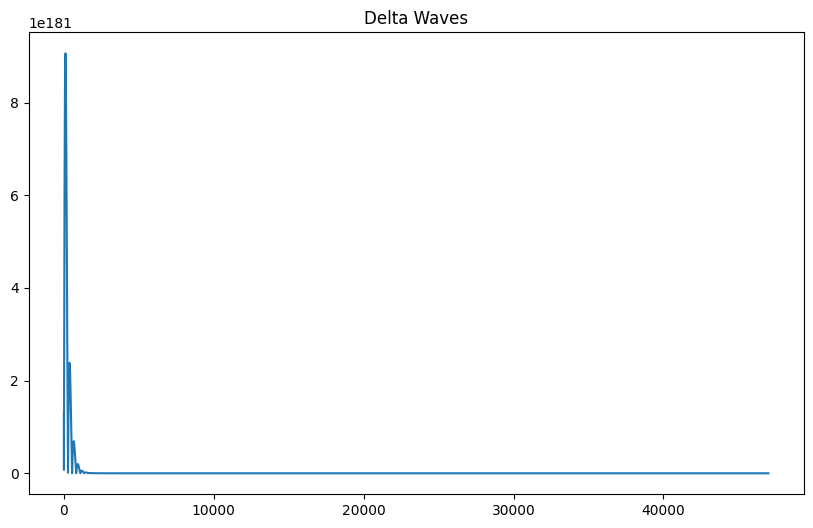

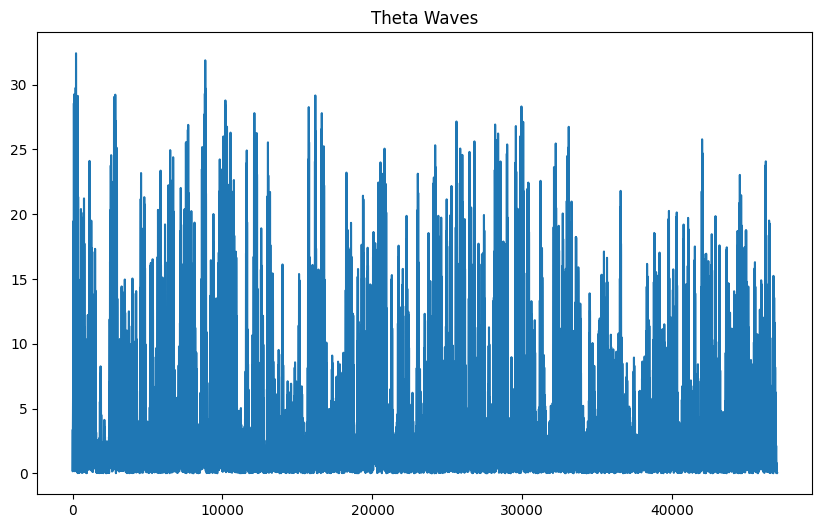

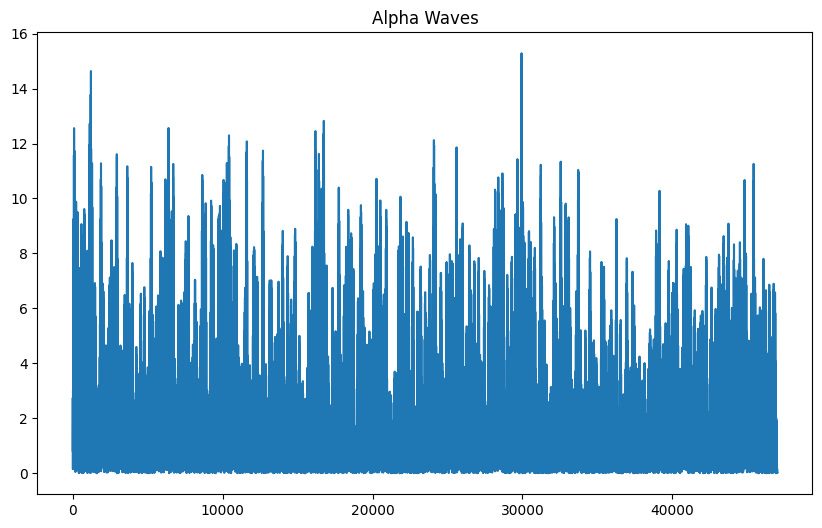

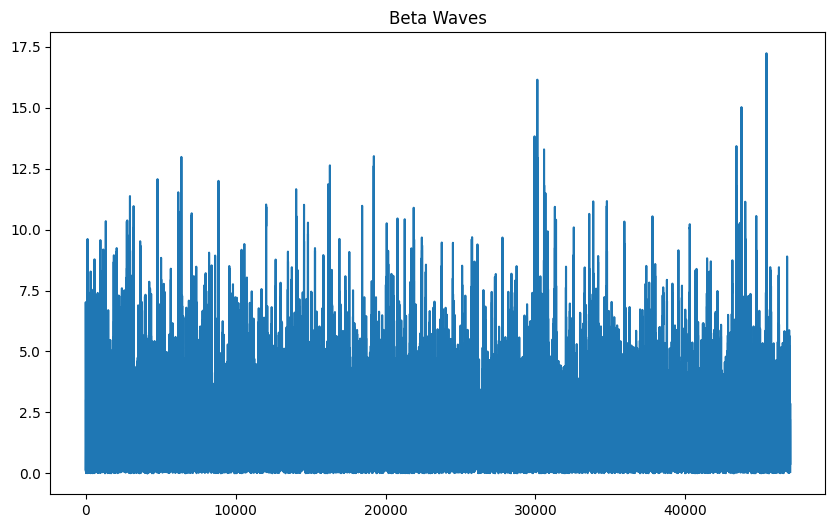

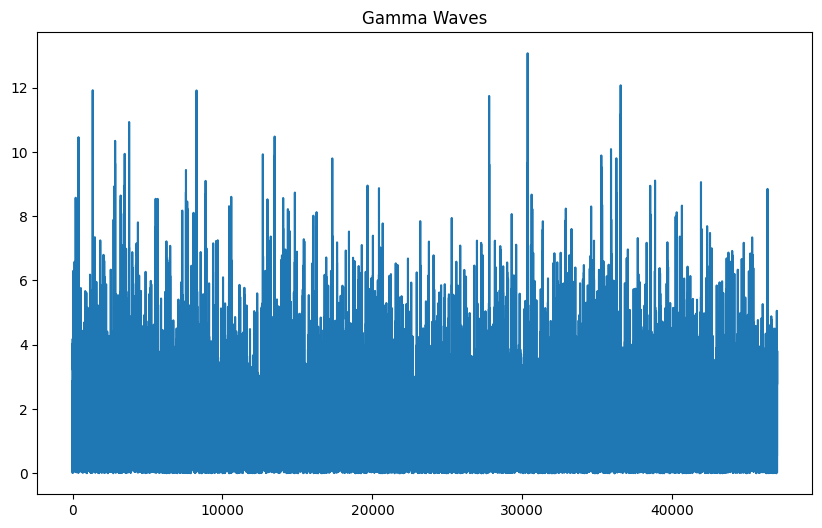

In [19]:
import matplotlib.pyplot as plt
import numpy as np

def extract_subpart_wave_amplitudes(signal, delta_freq_range, theta_freq_range, alpha_freq_range, beta_freq_range, gamma_freq_range):
    """Extracts the amplitudes of the delta, theta, alpha, beta, and gamma waves from an EEG signal.

    Args:
        signal (np.ndarray): The EEG signal.
        delta_freq_range (tuple): The frequency range of the delta waves (e.g., (0.5, 4)).
        theta_freq_range (tuple): The frequency range of the theta waves (e.g., (4, 7)).
        alpha_freq_range (tuple): The frequency range of the alpha waves (e.g., (8, 12)).
        beta_freq_range (tuple): The frequency range of the beta waves (e.g., (13, 30)).
        gamma_freq_range (tuple): The frequency range of the gamma waves (e.g., (32, 64)).

    Returns:
        dict: A dictionary containing the amplitudes of the delta, theta, alpha, beta, and gamma waves.
    """

    delta_amplitudes = bandpass_filter(signal, delta_freq_range)
    theta_amplitudes = bandpass_filter(signal, theta_freq_range)
    alpha_amplitudes = bandpass_filter(signal, alpha_freq_range)
    beta_amplitudes = bandpass_filter(signal, beta_freq_range)
    gamma_amplitudes = bandpass_filter(signal, gamma_freq_range)

    subpart_wave_amplitudes = {
        "delta": delta_amplitudes,
        "theta": theta_amplitudes,
        "alpha": alpha_amplitudes,
        "beta": beta_amplitudes,
        "gamma": gamma_amplitudes,
    }

    return subpart_wave_amplitudes

def bandpass_filter(signal, freq_range):
    """Filters an EEG signal within a specified frequency range.

    Args:
        signal (np.ndarray): The EEG signal.
        freq_range (tuple): The frequency range to filter within (e.g., (0.5, 4)).

    Returns:
        np.ndarray: The filtered signal.
    """

    from scipy.signal import butter, filtfilt

    fs = 128  # Sampling frequency in Hz
    lowcut, highcut = freq_range
    order = 5

    # Design the filter
    b, a = butter(order, [lowcut / fs, highcut / fs], btype='band')

    # Filter the signal
    filtered_signal = filtfilt(b, a, signal)

    # Calculate the amplitude of the filtered signal
    amplitudes = np.abs(filtered_signal)

    return amplitudes

# Example usage
signal = eeg_channel_data  # Simulate a 4-minute EEG signal

delta_freq_range = (0.5, 4)
theta_freq_range = (4, 7)
alpha_freq_range = (8, 12)
beta_freq_range = (13, 30)
gamma_freq_range = (32, 64)

subpart_wave_amplitudes = extract_subpart_wave_amplitudes(signal, delta_freq_range, theta_freq_range, alpha_freq_range, beta_freq_range, gamma_freq_range)

plt.figure(figsize=(10, 6))
# Plot the amplitudes of the delta waves
plt.plot(subpart_wave_amplitudes["delta"])
plt.title("Delta Waves")
plt.show()
plt.figure(figsize=(10, 6))
# Plot the amplitudes of the theta waves
plt.plot(subpart_wave_amplitudes["theta"])
plt.title("Theta Waves")
plt.show()
plt.figure(figsize=(10, 6))
# Plot the amplitudes of the alpha waves
plt.plot(subpart_wave_amplitudes["alpha"])
plt.title("Alpha Waves")
plt.show()
plt.figure(figsize=(10, 6))
# Plot the amplitudes of the beta waves
plt.plot(subpart_wave_amplitudes["beta"])
plt.title("Beta Waves")
plt.show()
plt.figure(figsize=(10, 6))
# Plot the amplitudes of the gamma waves
plt.plot(subpart_wave_amplitudes["gamma"])
plt.title("Gamma Waves")
plt.show()


In [ ]:
data_folder = "E:/STUDY/Publications/Thesis/Brain Emotion Detection/Dataset/Practice with datasets/Seed/Saved"

# Initialize arrays for features and labels
features = np.zeros((675, 62, max_vals, 5))
label_list = np.zeros(675)
trial = 0
# Loop through all files in the data folder
for filename in os.listdir(data_folder):
    if filename.endswith(".npy"):
        # Extract information from the filename
        parts = filename.split('_')
        subject_number = int(parts[1])
        trial_number = int(parts[2])
        feature_type = parts[3]
        # Extracting the label and removing parentheses
        label_str = parts[-1][:-4]  # Removing ".npy" extension
        label_str = label_str.replace('(', '').replace(')', '')  # Removing parentheses
        label = int(label_str)

        # Load the feature data
        feature_data = np.load(os.path.join(data_folder, filename), allow_pickle=True)

        # Add data and labels to the lists
        features[trial, :62, :feature_data.shape[1], :] = feature_data
        label_list[trial] = label

        trial += 1

# Convert lists to NumPy arrays
X = np.array(features)
y = np.array(label_list)



In [22]:
subpart_wave_amplitudes["delta"]

array([1.30062903e+181, 1.09888899e+181, 8.98967438e+180, ...,
       1.90313490e+090, 1.68904094e+090, 1.49056839e+090])

# Differential Entropy

In [32]:
import numpy as np

def differential_entropy(signal):
    """Calculates the differential entropy of a signal.

    Args:
        signal (np.ndarray): The signal to calculate the entropy of.

    Returns:
        float: The differential entropy of the signal.
    """

    # Calculate the probability density function (PDF) of the signal
    hist, bins = np.histogram(signal, bins=256)
    pdf = hist / np.sum(hist)

    # Calculate the differential entropy using the PDF
    entropy = 0
    for p in pdf:
        if p > 0:
            entropy += p * np.log2(p)

    # Return the negative of the entropy
    return -entropy

# Example usage
signal = subpart_wave_amplitudes["gamma"]  

entropy = differential_entropy(signal)
print("Differential entropy:", entropy)

# Higher the DE, the signal is unpredictable & requires a significant amount of information to represent.


Differential entropy: 6.382506576366192
